In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
pi = torch.Tensor([np.pi])
def sin_with_derivatives(x):
    y = torch.sin(2 * pi * x)
    dy = 2 * pi * torch.cos(2 * pi * x)
    ddy = - 4 * pi * pi * y
    return y, dy, ddy

In [3]:
torch.manual_seed(1234)
train_x = torch.linspace(0, 1, 11)
f, df, ddf = sin_with_derivatives(train_x)
train_y = torch.stack([f, df], -1).squeeze(1)
train_y += 0.1 * torch.randn(train_y.size())

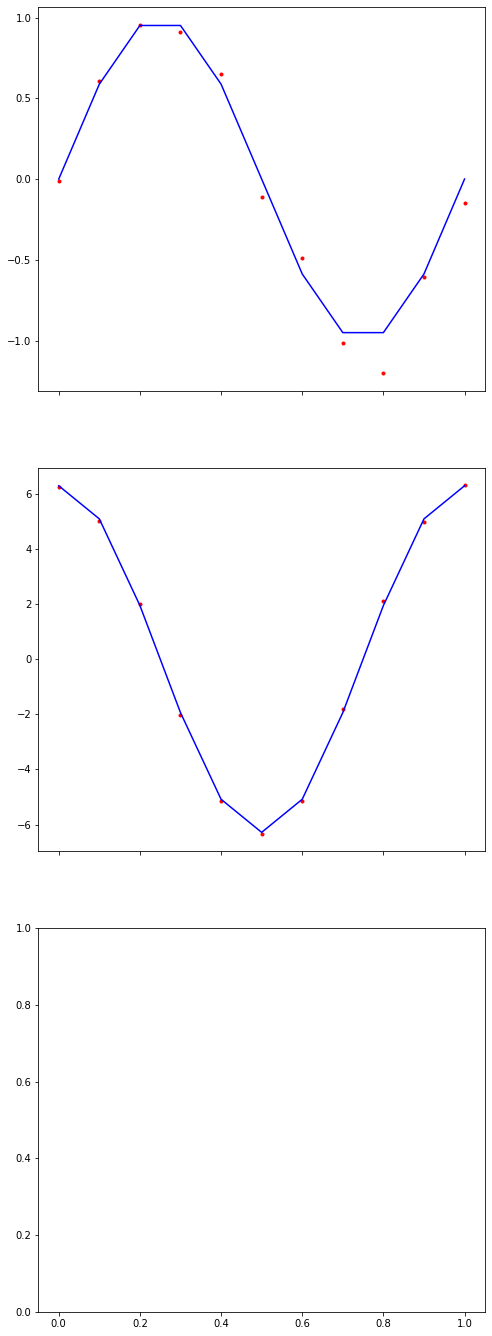

In [4]:
fig, ax = plt.subplots(3, 1, sharex = True, figsize = (8,24))
ax[0].plot(train_x, train_y[:,0], 'r.')
ax[0].plot(train_x, f, 'b-')
ax[1].plot(train_x, train_y[:,1], 'r.')
ax[1].plot(train_x, df, 'b-')
# ax[2].plot(train_x, train_y[:,2], 'r.')
# ax[2].plot(train_x, ddf, 'b-')

In [5]:
class GpWithGrad(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y1, likelihood):
        super(GpWithGrad, self).__init__(train_x, train_y1, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.kernel = gpytorch.kernels.RBFKernelGrad()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = GpWithGrad(train_x, train_y, likelihood)

model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for _ in tqdm(range(500)):
    
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [7]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

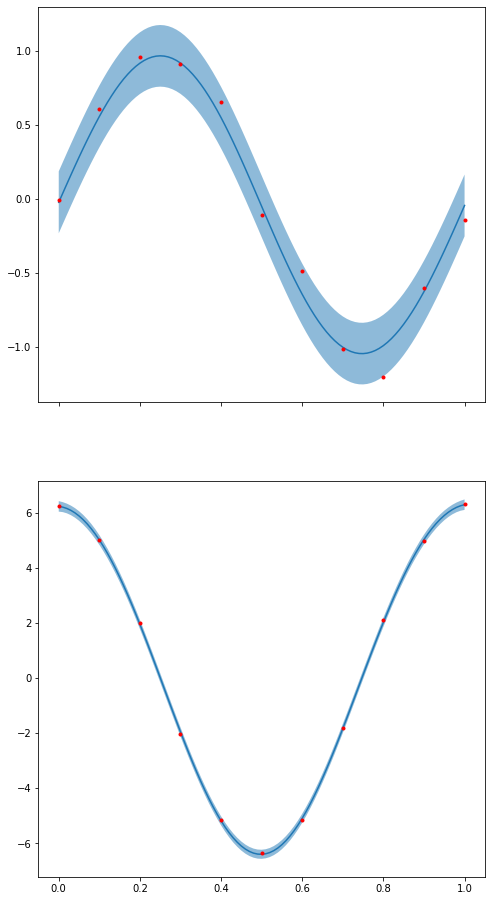

In [8]:
with torch.no_grad():
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 16))
    lower, upper = y_preds.confidence_region()
    ax[0].plot(test_x, y_preds.mean[:,0])
    ax[0].plot(train_x, train_y[:,0], 'r.')
    ax[0].fill_between(test_x, lower[:,0], upper[:,0], alpha = 0.5)
    ax[1].plot(test_x, y_preds.mean[:,1])
    ax[1].plot(train_x, train_y[:,1], 'r.')
    ax[1].fill_between(test_x, lower[:,1], upper[:,1], alpha = 0.5)

In [10]:
torch.manual_seed(1234)
train_x = torch.linspace(0, 1, 11)
f, df, ddf = sin_with_derivatives(train_x)
train_y = torch.stack([df, ddf], -1).squeeze(1)
train_y += 0.1 * torch.randn(train_y.size())

In [11]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = GpWithGrad(train_x, train_y, likelihood)

model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

for _ in tqdm(range(500)):
    
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()

In [12]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

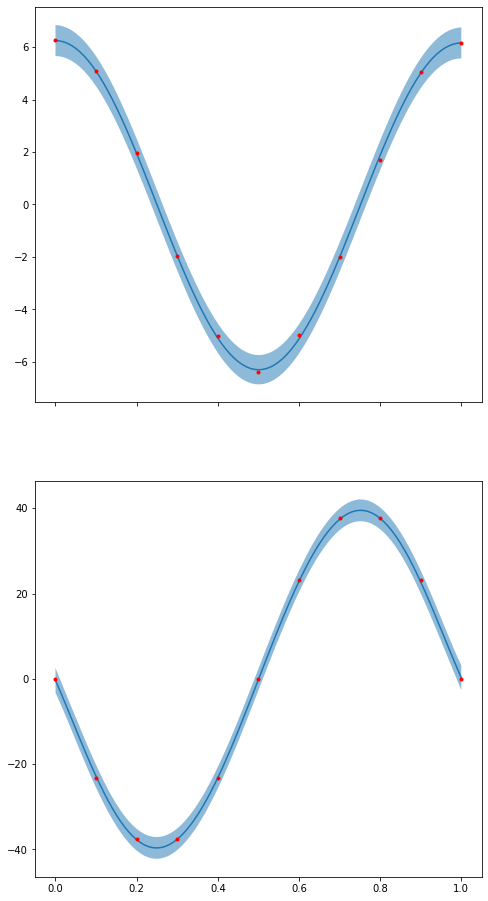

In [13]:
with torch.no_grad():
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 16))
    lower, upper = y_preds.confidence_region()
    ax[0].plot(test_x, y_preds.mean[:,0])
    ax[0].plot(train_x, train_y[:,0], 'r.')
    ax[0].fill_between(test_x, lower[:,0], upper[:,0], alpha = 0.5)
    ax[1].plot(test_x, y_preds.mean[:,1])
    ax[1].plot(train_x, train_y[:,1], 'r.')
    ax[1].fill_between(test_x, lower[:,1], upper[:,1], alpha = 0.5)